# Dropout

In this notebook, you will implement dropout.  Then we will ask you to train a network with batchnorm and dropout, and acheive over 55% accuracy on CIFAR-10.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [3]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  9.99876159164
Mean of train-time output:  9.98706418418
Mean of test-time output:  9.99876159164
Fraction of train-time output set to zero:  0.300888
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  9.99876159164
Mean of train-time output:  10.0051578499
Mean of test-time output:  9.99876159164
Fraction of train-time output set to zero:  0.599736
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  9.99876159164
Mean of train-time output:  10.0302996525
Mean of test-time output:  9.99876159164
Fraction of train-time output set to zero:  0.749128
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Implement the backward pass, `dropout_backward`, in `nndl/layers.py`.  After that, test your gradients by running the following cell:

In [4]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.89290743105e-11


## Implement a fully connected neural network with dropout layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer should be incorporated after every ReLU layer.  Concretely, there shouldn't be a dropout at the output layer since there is no ReLU at the output layer. You will need to modify the class in the following areas:

(1) In the forward pass, you will need to incorporate a dropout layer after every relu layer.

(2) In the backward pass, you will need to incorporate a dropout backward pass layer.

Check your implementation by running the following code.  Our W1 gradient relative error is on the order of 1e-6 (the largest of all the relative errors).

In [5]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
  print('\n')

Running check with dropout =  0
Initial loss:  2.3051948274
W1 relative error: 2.5272575351926774e-07
W2 relative error: 1.5034484932141387e-05
W3 relative error: 2.753446846744471e-07
b1 relative error: 2.9369574464090924e-06
b2 relative error: 5.051339805546953e-08
b3 relative error: 1.1740467838205477e-10


Running check with dropout =  0.25
Initial loss:  2.29898614757
W1 relative error: 9.737728851260064e-07
W2 relative error: 5.0736579542673615e-08
W3 relative error: 3.042456529982271e-08
b1 relative error: 2.0056188687011756e-08
b2 relative error: 1.897778283870511e-09
b3 relative error: 1.302003889798156e-10


Running check with dropout =  0.5
Initial loss:  2.30243758771
W1 relative error: 4.5533879914978946e-08
W2 relative error: 2.9742181126932173e-08
W3 relative error: 4.3413246880173414e-07
b1 relative error: 1.8724629972989974e-08
b2 relative error: 1.6327629805532402e-09
b3 relative error: 7.487013797161614e-11




## Dropout as a regularizer

In class, we claimed that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [6]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.6]
for dropout in dropout_choices:
  model = FullyConnectedNet([100, 100, 100], dropout=dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.300804
(Epoch 0 / 25) train acc: 0.220000; val_acc: 0.168000
(Epoch 1 / 25) train acc: 0.188000; val_acc: 0.147000
(Epoch 2 / 25) train acc: 0.266000; val_acc: 0.200000
(Epoch 3 / 25) train acc: 0.338000; val_acc: 0.262000
(Epoch 4 / 25) train acc: 0.378000; val_acc: 0.278000
(Epoch 5 / 25) train acc: 0.428000; val_acc: 0.297000
(Epoch 6 / 25) train acc: 0.468000; val_acc: 0.323000
(Epoch 7 / 25) train acc: 0.494000; val_acc: 0.287000
(Epoch 8 / 25) train acc: 0.566000; val_acc: 0.328000
(Epoch 9 / 25) train acc: 0.572000; val_acc: 0.322000
(Epoch 10 / 25) train acc: 0.622000; val_acc: 0.324000
(Epoch 11 / 25) train acc: 0.670000; val_acc: 0.279000
(Epoch 12 / 25) train acc: 0.710000; val_acc: 0.338000
(Epoch 13 / 25) train acc: 0.746000; val_acc: 0.319000
(Epoch 14 / 25) train acc: 0.792000; val_acc: 0.307000
(Epoch 15 / 25) train acc: 0.834000; val_acc: 0.297000
(Epoch 16 / 25) train acc: 0.876000; val_acc: 0.327000
(Epoch 17 / 25) train acc: 0.886000; val

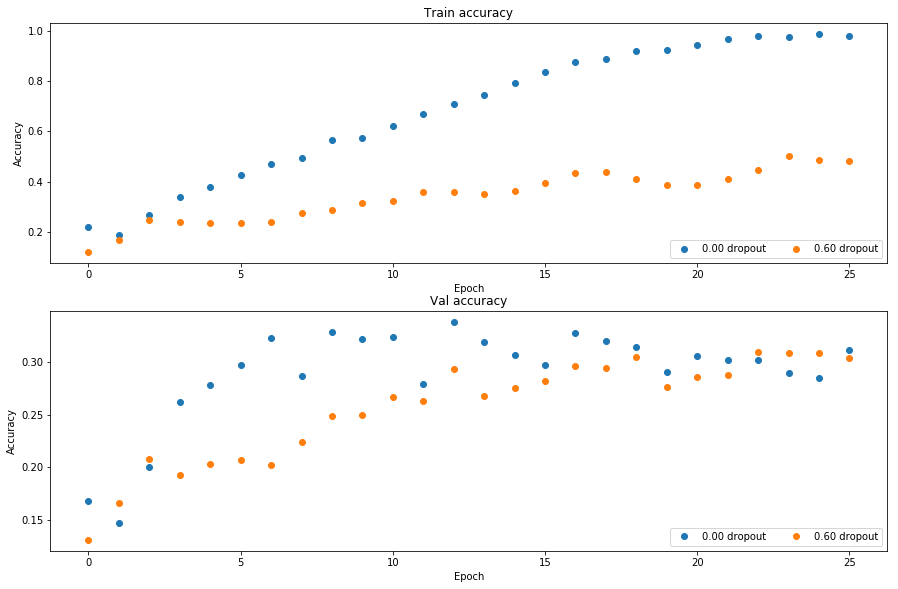

In [7]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Question

Based off the results of this experiment, is dropout performing regularization?  Explain your answer.

## Answer:
Regularization is defined as any modification of a learning algorithm that reduces the generalization error without reducing the training error. Indeed, during training non-zero dropout has worse error (top fig.), but during validation non-zero dropout eventually has better error (bottom fig.). Hence, these plots are consistent with the interpretation of dropout as regularization.

## Final part of the assignment

Get over 55% validation accuracy on CIFAR-10 by using the layers you have implemented.  You will be graded according to the following equation:

min(floor((X - 32%)) / 28%, 1) 
where if you get 60% or higher validation accuracy, you get full points.

In [120]:
# ================================================================ #
# YOUR CODE HERE:
#   Implement a FC-net that achieves at least 55% validation accuracy
#   on CIFAR-10.
# ================================================================ #


# Train two identical nets, one with dropout and one without

num_train = 49000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices =  [ 0.25, 0.2, 0.15] #  0.3, 0.25, 0.15, 0.1] #  0.7, 0.5,   [0.13, 0.15, 0.25, 0.2, 0.17, ,  0.12, 0.11]    #[0.17, 0.15, 0.13]   0.567 0.002 0.13 100
epochs = [35]
learning_rates = [   8e-4] 
# 0.008000 ; rain acc: 0.487000; val_acc: 0.429000 
# lr  0.001;  0.750000; val_acc: 0.553000
# lr 0.0005;  train acc: 0.711000; val_acc: 0.528000
# lr 0.0001; train acc: 0.579000; val_acc: 0.507000
# 2e-1,9e-2, 3e-2, 1e-2 , 9e-3, 8e-3, 7e-3 ,   1e-3, 9e-4, 8e-4, 5e-4, 1e-4]


#  learning rate 0.000800; epoch 35; dropout 0.200000;  train acc: 0.772000; val_acc: 0.580000

batches = [ 800]

best_lr = None
best_epo = None
best_do = None
best_solver = None
best_size = None
#best_hy = None


best_acc = 0
for size in batches:
    for lr in learning_rates:
        for epoch in epochs:
            for dropout in dropout_choices:
                print('We will use learning rate %f; epoch %d; dropout %f' %(lr,epoch, dropout) )
                model = FullyConnectedNet([700, 400, 400, 400, 100, 50], dropout=dropout)
    
                solver = Solver(model, small_data,
                      num_epochs=epoch, batch_size=size,
                      update_rule='adam',
                      optim_config={
                        'learning_rate': lr,
                      },
                      verbose=True, print_every=100)
                solver.train()
                acc = solver.best_val_acc
                if acc>best_acc:
                    best_acc = acc
                    best_lr = lr
                    best_epo = epoch
                    best_do = dropout
                    best_solver= solver
                    best_size = size
                    best_model = model

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
print('best val acc ', best_acc,'for learning rate: ', best_lr, ' and dropout rate: ', best_do, 'and epochs ', epochs[0], 'and size', best_size )

We will use learning rate 0.000800; epoch 35; dropout 0.250000
(Iteration 1 / 2135) loss: 2.302585
(Epoch 0 / 35) train acc: 0.131000; val_acc: 0.110000
(Epoch 1 / 35) train acc: 0.278000; val_acc: 0.277000
(Iteration 101 / 2135) loss: 1.776460
(Epoch 2 / 35) train acc: 0.325000; val_acc: 0.326000
(Epoch 3 / 35) train acc: 0.381000; val_acc: 0.379000
(Iteration 201 / 2135) loss: 1.750268
(Epoch 4 / 35) train acc: 0.407000; val_acc: 0.415000
(Iteration 301 / 2135) loss: 1.595897
(Epoch 5 / 35) train acc: 0.476000; val_acc: 0.447000
(Epoch 6 / 35) train acc: 0.501000; val_acc: 0.451000
(Iteration 401 / 2135) loss: 1.500134
(Epoch 7 / 35) train acc: 0.514000; val_acc: 0.495000
(Epoch 8 / 35) train acc: 0.550000; val_acc: 0.520000
(Iteration 501 / 2135) loss: 1.362064
(Epoch 9 / 35) train acc: 0.553000; val_acc: 0.511000
(Iteration 601 / 2135) loss: 1.408755
(Epoch 10 / 35) train acc: 0.519000; val_acc: 0.479000
(Epoch 11 / 35) train acc: 0.552000; val_acc: 0.516000
(Iteration 701 / 2135) 

(Epoch 31 / 35) train acc: 0.795000; val_acc: 0.567000
(Iteration 1901 / 2135) loss: 0.755856
(Epoch 32 / 35) train acc: 0.825000; val_acc: 0.572000
(Iteration 2001 / 2135) loss: 0.810583
(Epoch 33 / 35) train acc: 0.826000; val_acc: 0.569000
(Epoch 34 / 35) train acc: 0.861000; val_acc: 0.567000
(Iteration 2101 / 2135) loss: 0.650040
(Epoch 35 / 35) train acc: 0.820000; val_acc: 0.557000
best val acc  0.578 for learning rate:  0.0008  and dropout rate:  0.2 and epochs  35 and size 800


In [121]:
# Train two identical nets, one with dropout and one without

# num_train = 49000
# small_data = {
#   'X_train': data['X_train'][:num_train],
#   'y_train': data['y_train'][:num_train],
#   'X_val': data['X_val'],
#   'y_val': data['y_val'],
# }

print('implement change in the learning rate in the spirit of an elaborate leraning schedule')


solvers = {}
dropout_choices = [best_do]    #[0.17, 0.15, 0.13]   0.567 0.002 0.13 100
epoch = 12
xi = best_lr/12.0
learning_rates = [ xi ]      #[5e-3, 3.5e-3, 2.5e-3, 2e-3, 1e-3, 7e-4, 5e-4 ]
batches = [ 200]
size = 800

best_lr = None
best_epo = None
best_do = None
best_solver = None
best_size = None
#best_hy = None


best_acc = 0

print('We will use learning rate %f; epoch %d; dropout %f' %(lr,epoch, dropout) )
#model = FullyConnectedNet([200, 150, 100, 100, 100, 50, 50], dropout=dropout)

solver = Solver(best_model, small_data,
      num_epochs=epoch, batch_size=size,
      update_rule='adam',
      optim_config={
        'learning_rate': xi,
      },
      verbose=True, print_every=100)
solver.train()
acc = solver.best_val_acc
if acc>best_acc:
    best_acc = acc
    best_lr = xi
    best_epo = epoch
    best_do = dropout
    best_solver= solver
    best_size = size
    best_best_model = best_model


# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
print('best val acc ', best_acc,'for learning rate: ', best_lr, ' and dropout rate: ', best_do, 'and epochs ', epochs[0], 'and size', best_size )

implement change in the learning rate in the spirit of an elaborate leraning schedule
We will use learning rate 0.000800; epoch 40; dropout 0.150000
(Iteration 1 / 2440) loss: 0.890947
(Epoch 0 / 40) train acc: 0.743000; val_acc: 0.582000
(Epoch 1 / 40) train acc: 0.769000; val_acc: 0.592000
(Iteration 101 / 2440) loss: 0.840512
(Epoch 2 / 40) train acc: 0.785000; val_acc: 0.593000
(Epoch 3 / 40) train acc: 0.788000; val_acc: 0.583000
(Iteration 201 / 2440) loss: 0.772719
(Epoch 4 / 40) train acc: 0.795000; val_acc: 0.599000
(Iteration 301 / 2440) loss: 0.819006
(Epoch 5 / 40) train acc: 0.761000; val_acc: 0.595000
(Epoch 6 / 40) train acc: 0.813000; val_acc: 0.596000
(Iteration 401 / 2440) loss: 0.740634
(Epoch 7 / 40) train acc: 0.785000; val_acc: 0.597000
(Epoch 8 / 40) train acc: 0.797000; val_acc: 0.588000
(Iteration 501 / 2440) loss: 0.730205
(Epoch 9 / 40) train acc: 0.779000; val_acc: 0.600000
(Iteration 601 / 2440) loss: 0.774681
(Epoch 10 / 40) train acc: 0.812000; val_acc: 0

In [122]:
# Train two identical nets, one with dropout and one without

# num_train = 49000
# small_data = {
#   'X_train': data['X_train'][:num_train],
#   'y_train': data['y_train'][:num_train],
#   'X_val': data['X_val'],
#   'y_val': data['y_val'],
# }

print('implement change in the learning rate in the spirit of an elaborate leraning schedule')


solvers = {}
dropout_choices = [best_do]    #[0.17, 0.15, 0.13]   0.567 0.002 0.13 100
epoch = 12
xi = xi/12.0
learning_rates = [ xi ]      #[5e-3, 3.5e-3, 2.5e-3, 2e-3, 1e-3, 7e-4, 5e-4 ]
batches = [ 200]
size = 800

best_lr = None
best_epo = None
best_do = None
best_solver = None
best_size = None
#best_hy = None


best_acc = 0

print('We will use learning rate %f; epoch %d; dropout %f' %(lr,epoch, dropout) )
#model = FullyConnectedNet([200, 150, 100, 100, 100, 50, 50], dropout=dropout)

solver = Solver(best_best_model, small_data,
      num_epochs=epoch, batch_size=size,
      update_rule='adam',
      optim_config={
        'learning_rate': xi,
      },
      verbose=True, print_every=100)
solver.train()
acc = solver.best_val_acc
if acc>best_acc:
    best_acc = acc
    best_lr = xi
    best_epo = epoch
    best_do = dropout
    best_solver= solver
    best_size = size
    best_best_best_model = best_best_model


# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
print('best val acc ', best_acc,'for learning rate: ', xi, ' and dropout rate: ', best_do, 'and epochs ', epochs[0], 'and size', best_size )

implement change in the learning rate in the spirit of an elaborate leraning schedule
We will use learning rate 0.000800; epoch 12; dropout 0.150000
(Iteration 1 / 732) loss: 0.665470
(Epoch 0 / 12) train acc: 0.831000; val_acc: 0.605000
(Epoch 1 / 12) train acc: 0.840000; val_acc: 0.600000
(Iteration 101 / 732) loss: 0.751433
(Epoch 2 / 12) train acc: 0.847000; val_acc: 0.600000
(Epoch 3 / 12) train acc: 0.831000; val_acc: 0.599000
(Iteration 201 / 732) loss: 0.653424
(Epoch 4 / 12) train acc: 0.824000; val_acc: 0.599000
(Iteration 301 / 732) loss: 0.675666
(Epoch 5 / 12) train acc: 0.837000; val_acc: 0.600000
(Epoch 6 / 12) train acc: 0.862000; val_acc: 0.600000
(Iteration 401 / 732) loss: 0.740022
(Epoch 7 / 12) train acc: 0.829000; val_acc: 0.605000
(Epoch 8 / 12) train acc: 0.830000; val_acc: 0.600000
(Iteration 501 / 732) loss: 0.674710
(Epoch 9 / 12) train acc: 0.815000; val_acc: 0.599000
(Iteration 601 / 732) loss: 0.686065
(Epoch 10 / 12) train acc: 0.826000; val_acc: 0.598000